# Atividade 2
Escolher um dataset de NLP, e uma tarefa correspondente, (e.g., análise de sentimento em um dataset de postagens do twitter). Apresente sua solução esclarecendo todas as ideias.

O dataset escolhido foi do site kaggle, o desafio <i>Fake and real news dataset</i> para classificação de fake news. https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [1]:
import re
import pandas as pd
import string
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_fake = pd.read_csv("./data/Fake.csv")
df_true = pd.read_csv("./data/True.csv")

In [3]:
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [4]:
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

## Pré-processamento

Remoção de caracteres especiais, possiveis emotes, transformação para paravras minusculas, padronização, remoção de palavras irrelevantes, stemmer e vetorização. Tambem é feita a diminuição das amostras para 5 mil, pois a memoria do meu computador é limitada a 16GB. 

In [5]:
def text_preproc(x):
    x = x.lower()
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'@', ' ', x)
    x = re.sub(r'#', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x

def text_accent(row):
    row = ''.join(ch for ch in unicodedata.normalize('NFKD', row) 
        if not unicodedata.combining(ch))
    return row

def text_emojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def text_num_finds(row, regex):
    regex = re.compile(regex)
    return len(re.findall(regex, row))

In [6]:
df_fake['text'] = df_fake['text'].apply(text_emojify)
df_fake['text'] = df_fake['text'].apply(text_accent)
df_fake['text'] = df_fake['text'].apply(text_preproc)

df_true['text'] = df_true['text'].apply(text_emojify)
df_true['text'] = df_true['text'].apply(text_accent)
df_true['text'] = df_true['text'].apply(text_preproc)

In [7]:
df_fake["target"] = 0
df_true["target"] = 1

df_nlp = pd.concat([df_fake[["target", "text"]].sample(2500, replace=True),  
                    df_true[["target", "text"]].sample(2500, replace=True)])

In [8]:
df_nlp.head()

target                                               text
22628       0  21st century wire says regarding the latest tr...
18061       0  rebel pundit decided to follow a local activis...
20383       0  would hillary s every day americans answer the...
2117        0  one of the arguments against the affordable ca...
23195       0  tune in to the alternate current radio network...

In [9]:
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 22628 to 2555
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5000 non-null   int64 
 1   text    5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.2+ KB


In [10]:
import nltk
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

from pickle import dump, load

In [11]:
nltk.download("stopwords")
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')
nltk.download("rslp")
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também', 'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo', 'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'} 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/crassus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/crassus/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [12]:
def _tokenize_text(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

def _apply_standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []

        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]

            new_tokens.append(word) 

        ls.append(new_tokens)

    return ls

def _remove_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []

        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 

        ls.append(new_tokens)

    return ls

def _apply_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [13]:
df_nlp['text'] = _tokenize_text(df_nlp['text'])
df_nlp['text'] = _apply_standardization(df_nlp['text'], std_list)
df_nlp['text'] = _remove_stopwords(df_nlp['text'], nltk_stopwords)
df_nlp['text'] = _apply_stemmer(df_nlp['text'])
df_nlp['text'] = _untokenize_text(df_nlp['text'])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_nlp['text'])

In [14]:
features_names = vectorizer.get_feature_names()
dense_vector = X.todense()
list_vector = dense_vector.tolist()
text_tdidf = pd.DataFrame(list_vector, columns=features_names)
text_tdidf.dropna(inplace=True)

In [15]:
features = text_tdidf.values
target = df_nlp["target"].values

In [16]:
X_train, x_test, Y_train, y_test = train_test_split(features, target, test_size=0.3)

In [17]:
print(X_train.shape, Y_train.shape)
print(x_test.shape, y_test.shape)

(3500, 38506) (3500,)
(1500, 38506) (1500,)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
input_shape = X_train.shape[1]

In [20]:
model = Sequential()
model.add(Dense(256, input_shape=(input_shape,), activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
          bias_regularizer=regularizers.l2(1e-3),
          activity_regularizer=regularizers.l2(1e-4)))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=["acc"])

history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
28/28 [==============================] - 7s 178ms/step - loss: 2.1553 - acc: 0.8146 - val_loss: 0.6244 - val_acc: 0.9520
Epoch 2/10
28/28 [==============================] - 5s 169ms/step - loss: 0.5762 - acc: 0.9660 - val_loss: 0.6046 - val_acc: 0.9440
Epoch 3/10
28/28 [==============================] - 5s 170ms/step - loss: 0.4919 - acc: 0.9851 - val_loss: 0.5110 - val_acc: 0.9807
Epoch 4/10
28/28 [==============================] - 5s 167ms/step - loss: 0.4850 - acc: 0.9874 - val_loss: 0.5416 - val_acc: 0.9827
Epoch 5/10
28/28 [==============================] - 5s 167ms/step - loss: 0.4554 - acc: 0.9923 - val_loss: 0.5612 - val_acc: 0.9673
Epoch 6/10
28/28 [==============================] - 5s 166ms/step - loss: 0.4463 - acc: 0.9954 - val_loss: 0.4578 - val_acc: 0.9800
Epoch 7/10
28/28 [==============================] - 5s 170ms/step - loss: 0.3996 - acc: 0.9966 - val_loss: 0.4951 - val_acc: 0.9740
Epoch 8/10
28/28 [==============================] - 5s 168ms/step - loss: 0.

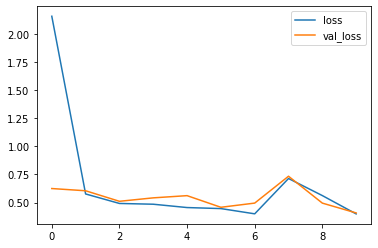

In [22]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label ="val_loss")
plt.legend();